In [100]:
import numpy as np
import matplotlib.pyplot as plt

# parameters (from assignment)
beta = 0.3      # transmission rate (week^-1)
alpha = 1.0     # recovery rate (week^-1)
tmax = 100      # simulation time
h = 0.1         # timestep for Euler's method

# geometric degree distribution: p_k = p(1-p)^k with p = 1/4
p = 0.25
max_k = 50      # maximum degree to consider
total_nodes = 10000  # total population size

# generate geometric degree distribution
degree_freq = []
for k in range(max_k):
    p_k = p * (1 - p)**k
    n_k = total_nodes * p_k
    degree_freq.append(int(n_k))

G_deg_sum = [a * b for a, b in zip(degree_freq, range(0, len(degree_freq)))]
total_degree = sum(G_deg_sum)
N = sum(degree_freq)
avg_k = total_degree / N if N > 0 else 0

print(f"Network Statistics:")
print(f"  Total nodes: {N}")
print(f"  Average degree: {avg_k:.3f}")
print(f"  Max degree: {max_k}")
print(f"  Degree distribution: {degree_freq[:30]}...")

Network Statistics:
  Total nodes: 9984
  Average degree: 2.976
  Max degree: 50
  Degree distribution: [2500, 1875, 1406, 1054, 791, 593, 444, 333, 250, 187, 140, 105, 79, 59, 44, 33, 25, 18, 14, 10, 7, 5, 4, 3, 2, 1, 1, 1, 0, 0]...


In [101]:
def ODEs(I_U, I_V, N_U, N_V, beta, alpha, k, theta, rho):
    """
    SIS equations WITH vaccination - only calculating dI
    S is derived from conservation: S = N - I
    
    Parameters:
    -----------
    I_U : Unvaccinated infected with degree k
    I_V : Vaccinated infected with degree k
    N_U : Total unvaccinated population with degree k
    N_V : Total vaccinated population with degree k
    theta : Modified probability accounting for reduced transmission
    """
    # Calculate S from conservation per feedback
    S_U = N_U - I_U
    S_V = N_V - I_V
    
    # Only calculate dI (dS is not needed since S = N - I)
    dI_U = S_U * k * theta * beta - alpha * I_U
    dI_V = S_V * (1 - rho) * k * theta * beta - alpha * I_V
    
    return dI_U, dI_V

In [102]:
def run_hmf_vaccination(rho, vaccinate_high_degree=False, vaccination_fraction=0.4):
    """    
    Parameters:
    -----------
    rho : float
        Vaccination efficacy (0 = no effect, 1 = perfect protection)
    vaccinate_high_degree : bool
        If True, vaccinate highest degree nodes first (part d)
        If False, vaccinate randomly across all degrees (part c)
    vaccination_fraction : float
        Fraction of population to vaccinate (default 0.4 = 40%)
    
    Returns:
    --------
    tuple : (T, St, It)
        Time array, susceptible fraction over time, infected fraction over time
    """
    # initial conditions
    I0 = 0.01           # Initial fraction infected
    S0 = 1.0 - I0       # Initial fraction susceptible
    
    N_U_k = np.zeros(len(degree_freq))  # unvaccinated population
    N_V_k = np.zeros(len(degree_freq))  # vaccinated population
    I_U_k = np.zeros(len(degree_freq))  # unvaccinated infected
    I_V_k = np.zeros(len(degree_freq))  # vaccinated infected
    
    
    # populate initial conditions
    for k in range(len(degree_freq)):
        N_U_k[k] = degree_freq[k] # total unvaccinated population at degree k 
        I_U_k[k] = degree_freq[k] * I0
        N_V_k[k] = 0.0
        I_V_k[k] = 0.0
    
    # c and d
    if vaccinate_high_degree:
        # Targeted vaccination
        total_to_vaccinate = N * vaccination_fraction
        vaccinated_count = 0
        
        # (-1, -1, -1): begin with highest degree nodes, stops at index 0, decrements by 1 each iteration
        for k in range(len(degree_freq)-1, -1, -1):
            if vaccinated_count >= total_to_vaccinate:
                break
            S_U_current = N_U_k[k] - I_U_k[k] # leveraging conserved quantities

            # example: if degree_freq[k] = 1000, total_to_vaccinate = 4000, vaccinated_count = 0
            # nodes_to_vaccinate = min(1000, 4000 - 0) = 1000
            # fraction_to_vaccinate = 1000 / 1000 = 1
            # S_V_k[k] = S_U_k[k] * 1 = 1000
            # S_U_k[k] = S_U_k[k] * (1 - 1) = 0
            nodes_to_vaccinate = min(
                S_U_current,  # Can only vaccinate susceptibles
                total_to_vaccinate - vaccinated_count
            )
            
            # Move susceptibles from U to V
            N_V_k[k] += nodes_to_vaccinate
            N_U_k[k] -= nodes_to_vaccinate
            
            vaccinated_count += nodes_to_vaccinate

    else:
        # Random vaccination
        for k in range(len(degree_freq)):
            S_U_current = N_U_k[k] - I_U_k[k]
            nodes_to_vaccinate = S_U_current * vaccination_fraction
            
            N_V_k[k] = nodes_to_vaccinate
            N_U_k[k] = degree_freq[k] - nodes_to_vaccinate

    
    # euler's method
    res = []
    T = np.arange(0, tmax/h)
    
    for t in T:
        # Calculate modified theta from part (b)
        numerator = sum(k * (I_U_k[k] + (1 - rho) * I_V_k[k]) for k in range(len(degree_freq))) # exactly the same as the numerator in theta calculation from part b
        denominator = total_degree
        theta = numerator / denominator if denominator > 0 else 0
        
        # Update each degree class
        for k in range(len(degree_freq)):
            dI_U, dI_V = ODEs(
                I_U_k[k], I_V_k[k], N_U_k[k], N_V_k[k],
                beta, alpha, k, theta, rho
            )
            
            # Euler's method
            I_U_k[k] += dI_U * h
            I_V_k[k] += dI_V * h
        
        # Track totals
        S_total = np.sum(N_U_k - I_U_k) + np.sum(N_V_k - I_V_k) # leveraging conserved quantities

        I_total = np.sum(I_U_k) + np.sum(I_V_k)
        
        res.append((S_total/N, I_total/N))
    
    St, It = map(np.array, zip(*res))
    return h*T, St, It

ρ = 0.50: Peak I = 0.0990, Final S = 0.9010
ρ = 0.70: Peak I = 0.0639, Final S = 0.9361
ρ = 0.90: Peak I = 0.0441, Final S = 0.9559
ρ = 0.95: Peak I = 0.0414, Final S = 0.9586
ρ = 0.99: Peak I = 0.0399, Final S = 0.9601


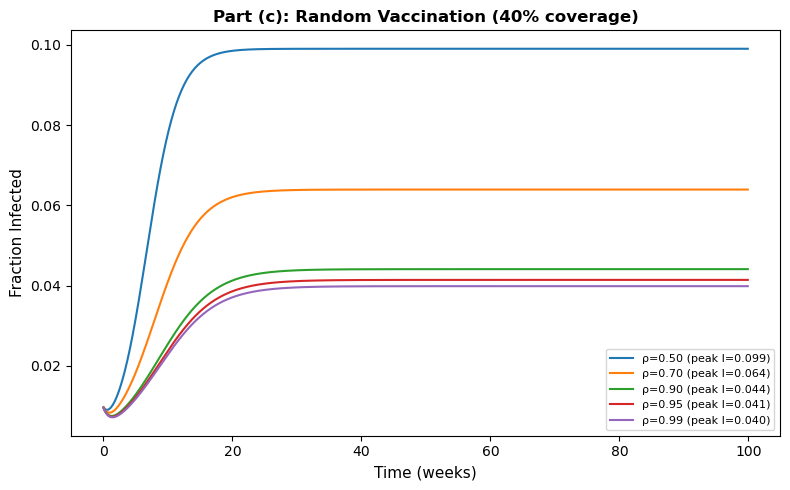

In [103]:
# random vaccination
rho_values = [0.5, 0.7, 0.9, 0.95, 0.99]
fig, axes = plt.subplots(figsize=(8, 5))
for rho in rho_values:
    T, St, It = run_hmf_vaccination(rho, vaccinate_high_degree=False)
    peak_I = np.max(It)
    final_S = St[-1]
    
    axes.plot(T, It, label=f'ρ={rho:.2f} (peak I={peak_I:.3f})')
    print(f"ρ = {rho:.2f}: Peak I = {peak_I:.4f}, Final S = {final_S:.4f}")

axes.set_xlabel('Time (weeks)', fontsize=11)
axes.set_ylabel('Fraction Infected', fontsize=11)
axes.set_title('Part (c): Random Vaccination (40% coverage)', fontsize=12, fontweight='bold')
axes.legend(fontsize=8)

plt.tight_layout()
plt.savefig('vaccination_comparison_random.png', dpi=150, bbox_inches='tight')
plt.show()

ρ = 0.50: Peak I = 0.0095, Final S = 1.0000
ρ = 0.70: Peak I = 0.0094, Final S = 1.0000
ρ = 0.90: Peak I = 0.0092, Final S = 1.0000
ρ = 0.95: Peak I = 0.0092, Final S = 1.0000
ρ = 0.99: Peak I = 0.0092, Final S = 1.0000


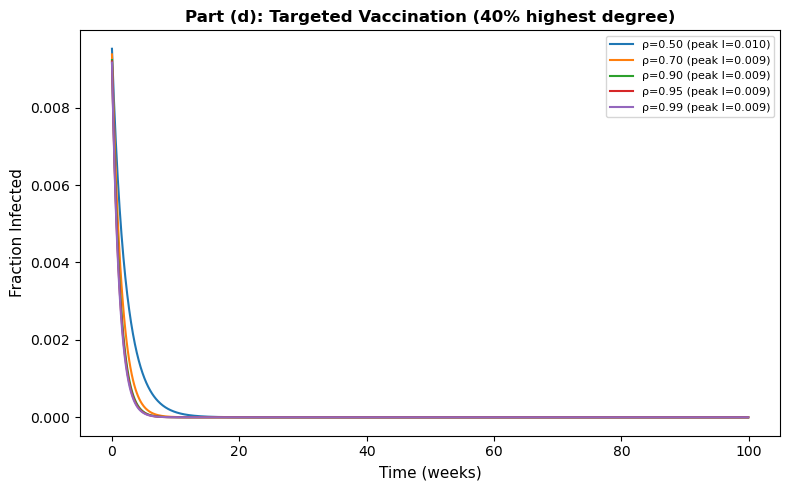

In [105]:
# target high degree nodes

rho_values = [0.5, 0.7, 0.9, 0.95, 0.99]

fig, axes = plt.subplots(figsize=(8, 5))
for rho in rho_values:
    T, St, It = run_hmf_vaccination(rho, vaccinate_high_degree=True)
    peak_I = np.max(It)
    final_S = St[-1]
    
    axes.plot(T, It, label=f'ρ={rho:.2f} (peak I={peak_I:.3f})')
    print(f"ρ = {rho:.2f}: Peak I = {peak_I:.4f}, Final S = {final_S:.4f}")

axes.set_xlabel('Time (weeks)', fontsize=11)
axes.set_ylabel('Fraction Infected', fontsize=11)
axes.set_title('Part (d): Targeted Vaccination (40% highest degree)', fontsize=12, fontweight='bold')
axes.legend(fontsize=8)

plt.tight_layout()
plt.savefig('vaccination_comparison_targeted.png', dpi=150, bbox_inches='tight')
plt.show()